# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes



config = {
    'function_family': {
        'maximum_depth': 3,
        'fully_grown': True,                      
    },
    'data': {
        'number_of_variables': 3, 
        'num_classes': 2,
        
        'function_generation_type': 'make_classification', # 'make_classification' 'random_decision_tree' 'random_decision_tree_trained'
        'objective': 'classification', # 'regression'
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform',       
                
        'lambda_dataset_size': 1000, #number of samples per function
        #'number_of_generated_datasets': 10000,
        
        'noise_injected_level': 0, 
        'noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'
    }, 
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True, 
        'early_stopping_min_delta_lambda': 1e-2,
        'batch_lambda': 64,
        'dropout_lambda': 0,
        'lambda_network_layers': [64],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'binary_crossentropy', #categorical_crossentropy
        
        'number_of_lambda_weights': None,
        
        'number_initializations_lambda': 1, 
        
        'number_of_trained_lambda_nets': 10000,
    },     
    
    'i_net': {
        'dense_layers': [1056, 512],
        'convolution_layers': None,
        'lstm_layers': None,
        'dropout': [0.2, 0.1],
        
        'optimizer': 'adam', #adam
        'learning_rate': 0.001,
        'loss': 'binary_crossentropy',
        'metrics': ['binary_accuracy'],
        
        'epochs': 2000, 
        'early_stopping': True,
        'batch_size': 256,

        'interpretation_dataset_size': 10000,
                
        'test_size': 50, #Float for fraction, Int for number 0
        
        'function_representation_type': 1, 

        'optimize_decision_function': True, #False
        'function_value_loss': True, #False
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 100,
    },    
    
    'evaluation': {   
        #'inet_holdout_seed_evaluation': False,
            
        'random_evaluation_dataset_size': 5000,
        'per_network_optimization_dataset_size': 5000,

        'sklearn_dt_benchmark': False,
        'sdt_benchmark': False,
        
    },    
    
    'computation':{
        'load_model': False,
        
        'n_jobs': -3,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}


## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score

from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import tensorflow as tf
import tensorflow_addons as tfa
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import tensorflow.keras.backend as K
from livelossplot import PlotLossesKerasTF
#from keras_tqdm import TQDMNotebookCallback

from matplotlib import pyplot as plt
import seaborn as sns


import random 


import warnings

from IPython.display import Image
from IPython.display import display, Math, Latex, clear_output



In [4]:
tf.__version__

'2.4.1'

In [5]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [6]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################

config['i_net']['data_reshape_version'] = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version

#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
#os.environ['XLA_FLAGS'] =  '--xla_gpu_cuda_data_dir=/usr/lib/cuda-10.1'

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=200)

warnings.filterwarnings('ignore')

In [7]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
from utilities.DecisionTree_BASIC import *

#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

config['lambda_net']['number_of_lambda_weights'] = get_number_of_lambda_net_parameters(lambda_network_layers, number_of_variables, num_classes)
config['function_family']['function_representation_length'] = (2 ** maximum_depth - 1) * (number_of_variables + 1) + (2 ** maximum_depth) * num_classes

#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

#initialize_LambdaNet_config_from_curent_notebook(config)
#initialize_metrics_config_from_curent_notebook(config)
#initialize_utility_functions_config_from_curent_notebook(config)
#initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='interpretation_net'))
create_folders_inet(config)

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [8]:
print(path_identifier_interpretation_net)

print(path_identifier_lambda_net_data)


lNetSize1000_numLNets10000_var3_class2_make_classification_xMax1_xMin0_xDistuniform_depth3_fullyGrown/64_e1000ES0.01_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42/inet_dense1056-512_drop0.2-0.1e2000b256_adam
lNetSize1000_numLNets10000_var3_class2_make_classification_xMax1_xMin0_xDistuniform_depth3_fullyGrown/64_e1000ES0.01_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42


In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(config, no_noise=False, n_jobs=1):
    
    #def generate_lambda_net()
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    if no_noise==True:
        config['noise_injected_level'] = 0
    path_dict = generate_paths(config, path_type='interpretation_net')        
        
    directory = './data/weights/' + 'weights_' + path_dict['path_identifier_lambda_net_data'] + '/'
    path_network_parameters = directory + 'weights' + '.txt'
    path_X_data = directory + 'X_test_lambda.txt'
    path_y_data = directory + 'y_test_lambda.txt'        
    
    network_parameters = pd.read_csv(path_network_parameters, sep=",", header=None)
    network_parameters = network_parameters.sort_values(by=0)
    if no_noise == False:
        network_parameters = network_parameters.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
    
    X_test_lambda = pd.read_csv(path_X_data, sep=",", header=None)
    X_test_lambda = X_test_lambda.sort_values(by=0)
    if no_noise == False:
        X_test_lambda = X_test_lambda.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
    
    y_test_lambda = pd.read_csv(path_y_data, sep=",", header=None)
    y_test_lambda = y_test_lambda.sort_values(by=0)
    if no_noise == False:
        y_test_lambda = y_test_lambda.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
        
        
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky') #loky

    lambda_nets = parallel(delayed(LambdaNet)(network_parameters_row, 
                                              X_test_lambda_row, 
                                              y_test_lambda_row, 
                                              config) for network_parameters_row, X_test_lambda_row, y_test_lambda_row in zip(network_parameters.values, X_test_lambda.values, y_test_lambda.values))          
    del parallel
    
    base_model = generate_base_model(config)  
    
    def initialize_network_wrapper(config, lambda_net, base_model):
        lambda_net.initialize_network(config, base_model)
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='sequential')
    _ = parallel(delayed(initialize_network_wrapper)(config, lambda_net, base_model) for lambda_net in lambda_nets)   
    del parallel
    
    def initialize_target_function_wrapper(config, lambda_net):
        lambda_net.initialize_target_function(config)
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='sequential')
    _ = parallel(delayed(initialize_target_function_wrapper)(config, lambda_net) for lambda_net in lambda_nets)   
    del parallel
        
    
    #lambda_nets = [None] * network_parameters.shape[0]
    #for i, (network_parameters_row, X_test_lambda_row, y_test_lambda_row) in tqdm(enumerate(zip(network_parameters.values, X_test_lambda.values, y_test_lambda.values)), total=network_parameters.values.shape[0]):        
    #    lambda_net = LambdaNet(network_parameters_row, X_test_lambda_row, y_test_lambda_row, config)
    #    lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA
if noise_injected_level > 0:
    lambda_net_dataset_training = load_lambda_nets(config, no_noise=True, n_jobs=n_jobs)
    lambda_net_dataset_evaluation = load_lambda_nets(config, n_jobs=n_jobs)

    lambda_net_dataset_train, lambda_net_dataset_valid = split_LambdaNetDataset(lambda_net_dataset_training, test_split=0.1)
    _, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset_evaluation, test_split=test_size)
    
else:
    lambda_net_dataset = load_lambda_nets(config, n_jobs=n_jobs)

    lambda_net_dataset_train_with_valid, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
    lambda_net_dataset_train, lambda_net_dataset_valid = split_LambdaNetDataset(lambda_net_dataset_train_with_valid, test_split=0.1)

    

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-3)]: Done   4 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-3)]: Done 161 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-3)]: Done 5006 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-3)]: Done 10000 out of 10000 | elapsed:    9.5s finished
[Parallel(n_jobs=-3)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-3)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-3)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-3)]: Done 10000 out of 10000 | elapsed:  4.1min finished
[Parallel(n_jobs=-3)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-3)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-3)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-3)]: Done 10000 out of 10000 | elapsed:    9.2s finished


## Data Inspection

In [12]:
lambda_net_dataset_train.shape

(8955, 367)

In [13]:
lambda_net_dataset_valid.shape

(995, 367)

In [14]:
lambda_net_dataset_test.shape

(50, 367)

In [15]:
lambda_net_dataset_train.as_pandas(config).head()

,index,seed,f0v0,f0v1,f0v2,f1v0,f1v1,f1v2,f2v0,f2v1,f2v2,f3v0,f3v1,f3v2,f4v0,f4v1,f4v2,f5v0,f5v1,f5v2,f6v0,f6v1,f6v2,b0,b1,b2,b3,b4,b5,b6,lp0c0,lp0c1,lp1c0,lp1c1,lp2c0,lp2c1,lp3c0,lp3c1,lp4c0,lp4c1,lp5c0,lp5c1,lp6c0,lp6c1,lp7c0,lp7c1,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,...,wb_221,wb_222,wb_223,wb_224,wb_225,wb_226,wb_227,wb_228,wb_229,wb_230,wb_231,wb_232,wb_233,wb_234,wb_235,wb_236,wb_237,wb_238,wb_239,wb_240,wb_241,wb_242,wb_243,wb_244,wb_245,wb_246,wb_247,wb_248,wb_249,wb_250,wb_251,wb_252,wb_253,wb_254,wb_255,wb_256,wb_257,wb_258,wb_259,wb_260,wb_261,wb_262,wb_263,wb_264,wb_265,wb_266,wb_267,wb_268,wb_269,wb_270,wb_271,wb_272,wb_273,wb_274,wb_275,wb_276,wb_277,wb_278,wb_279,wb_280,wb_281,wb_282,wb_283,wb_284,wb_285,wb_286,wb_287,wb_288,wb_289,wb_290,wb_291,wb_292,wb_293,wb_294,wb_295,wb_296,wb_297,wb_298,wb_299,wb_300,wb_301,wb_302,wb_303,wb_304,wb_305,wb_306,wb_307,wb_308,wb_309,wb_310,wb_311,wb_312,wb_313,wb_314,wb_315,wb_316,wb_317,wb_318,wb_319,wb_320
6671,6671.000,42,1.336,0.954,2.105,1.615,-0.184,1.760,0.456,-0.705,-2.711,0.765,0.551,1.249,-0.256,0.890,-0.162,0.008,-0.790,-1.251,1.539,0.529,-0.236,-1.060,0.837,0.790,1.099,0.355,1.657,-0.103,-3.041,3.319,0.221,-0.199,1.859,-1.850,-0.000,-0.000,1.999,-1.797,-0.000,-0.000,-0.000,0.000,-2.560,2.560,-0.031,-0.244,0.154,-0.162,-0.073,-0.031,0.088,-0.116,-0.103,-0.064,0.352,-0.042,0.020,-0.045,0.096,0.087,0.010,-0.080,-0.232,-0.106,-0.141,-0.020,-0.248,0.046,0.294,0.010,-0.056,0.074,-0.089,-0.009,-0.070,0.179,0.223,0.142,-0.033,0.022,-0.239,0.362,0.021,-0.067,0.085,0.084,0.184,0.177,0.218,0.125,0.229,-0.066,0.095,-0.207,0.283,-0.058,-0.065,-0.097,...,0.031,-0.035,-0.082,-0.088,-0.103,0.166,0.268,0.302,0.204,-0.060,0.321,0.271,-0.082,-0.102,-0.097,-0.003,-0.085,-0.082,0.305,-0.096,-0.093,0.188,0.267,0.269,0.166,0.188,0.235,0.248,0.154,-0.125,-0.070,0.360,-0.107,-0.093,-0.080,-0.356,0.231,0.329,-0.511,-0.588,0.340,0.077,-0.150,-0.189,-0.609,0.572,-0.229,-0.312,-0.391,0.112,0.062,-0.215,-0.143,0.236,-0.307,-0.188,-0.081,0.294,0.238,0.553,0.261,-0.276,0.057,-0.264,-0.056,-0.187,0.174,0.212,0.108,-0.289,0.400,0.333,0.643,-0.023,-0.723,0.216,0.066,0.163,0.163,0.242,0.112,0.248,-0.714,0.079,-0.321,0.423,-0.465,-0.577,-0.357,-0.229,0.414,0.254,-0.361,-0.133,0.188,-0.500,0.187,-0.151,0.313,-0.038
3274,3274.000,42,1.245,-0.395,-1.320,0.149,1.065,-1.209,-0.191,-1.837,1.130,0.554,0.535,-1.022,0.068,-0.672,-0.179,1.648,0.105,0.819,-0.736,0.012,-1.468,-1.644,0.251,0.862,0.338,0.195,-0.382,0.214,-2.253,2.135,0.000,0.000,-1.067,1.067,0.003,-0.008,2.392,-2.360,-1.698,1.851,2.775,-3.009,-0.099,0.098,-0.265,-0.649,-0.003,-0.224,-0.178,-0.274,-0.045,-0.393,-0.210,-0.208,0.095,-0.077,-0.667,-0.161,0.479,-0.075,-0.597,0.158,-0.619,-0.335,-0.187,0.485,-0.801,-0.831,0.073,0.754,-0.572,-0.114,-0.134,-0.621,-0.440,0.255,0.233,0.428,-0.284,-0.083,-0.432,0.100,-0.262,-0.212,-0.847,0.375,0.409,0.365,0.063,0.132,0.301,-0.221,-0.126,-0.398,0.040,-0.082,-0.150,-0.355,...,0.159,-0.209,-0.156,-0.132,-0.208,-0.137,0.009,0.073,-0.271,0.092,-0.101,0.251,-0.211,-0.208,-0.190,-0.079,-0.143,-0.151,-0.071,-0.040,-0.213,-0.099,-0.123,-0.133,-0.181,-0.280,-0.085,0.060,-0.232,0.134,-0.106,0.186,-0.198,-0.112,-0.127,-0.462,0.488,0.077,-0.349,-0.160,0.277,0.559,-0.486,-0.406,-0.205,0.157,-0.096,0.606,-0.273,0.700,0.449,0.507,-0.345,0.492,-0.658,-0.296,-0.626,0.540,0.860,0.109,-0.735,-0.737,0.422,-0.161,0.581,-0.742,0.705,0.502,0.824,-0.333,0.083,0.370,0.084,0.395,-0.217,0.786,0.749,0.848,0.860,0.039,0.602,0.582,-0.244,0.519,-0.739,0.076,-0.051,-0.162,-0.535,-0.693,0.292,0.213,-0.627,-0.339,0.473,-0.371,0.856,-0.272,0.356,-0.132
3095,3095.000,42,1.458,-0.321,-1.689,-1.649,-1.050,0.076,1.561,0.678,1.302,0.022,-0.486,0.299,0.675,1.337,-0.819,-0.393,

In [16]:
lambda_net_dataset_valid.as_pandas(config).head()

,index,seed,f0v0,f0v1,f0v2,f1v0,f1v1,f1v2,f2v0,f2v1,f2v2,f3v0,f3v1,f3v2,f4v0,f4v1,f4v2,f5v0,f5v1,f5v2,f6v0,f6v1,f6v2,b0,b1,b2,b3,b4,b5,b6,lp0c0,lp0c1,lp1c0,lp1c1,lp2c0,lp2c1,lp3c0,lp3c1,lp4c0,lp4c1,lp5c0,lp5c1,lp6c0,lp6c1,lp7c0,lp7c1,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,...,wb_221,wb_222,wb_223,wb_224,wb_225,wb_226,wb_227,wb_228,wb_229,wb_230,wb_231,wb_232,wb_233,wb_234,wb_235,wb_236,wb_237,wb_238,wb_239,wb_240,wb_241,wb_242,wb_243,wb_244,wb_245,wb_246,wb_247,wb_248,wb_249,wb_250,wb_251,wb_252,wb_253,wb_254,wb_255,wb_256,wb_257,wb_258,wb_259,wb_260,wb_261,wb_262,wb_263,wb_264,wb_265,wb_266,wb_267,wb_268,wb_269,wb_270,wb_271,wb_272,wb_273,wb_274,wb_275,wb_276,wb_277,wb_278,wb_279,wb_280,wb_281,wb_282,wb_283,wb_284,wb_285,wb_286,wb_287,wb_288,wb_289,wb_290,wb_291,wb_292,wb_293,wb_294,wb_295,wb_296,wb_297,wb_298,wb_299,wb_300,wb_301,wb_302,wb_303,wb_304,wb_305,wb_306,wb_307,wb_308,wb_309,wb_310,wb_311,wb_312,wb_313,wb_314,wb_315,wb_316,wb_317,wb_318,wb_319,wb_320
3466,3466.000,42,-1.206,3.094,-1.627,-1.719,-1.459,-0.294,-0.504,1.146,-2.571,-0.440,-0.474,-1.578,-0.376,0.511,-0.921,0.511,-0.973,-0.718,1.693,1.336,-0.353,0.208,1.106,0.141,1.133,-0.608,0.694,0.795,2.820,-2.655,1.752,-1.750,-0.311,0.314,-1.242,1.339,-2.968,2.688,0.025,-0.022,-3.012,2.946,2.835,-2.911,-0.040,-0.036,0.370,-0.301,-0.322,0.415,0.116,-0.325,-0.357,-0.327,0.490,-0.080,0.026,-0.199,0.337,0.135,0.019,-0.095,-0.022,-0.055,-0.290,-0.051,0.008,0.326,0.513,0.338,-0.066,0.118,-0.273,0.023,-0.128,0.410,0.229,0.308,-0.061,0.262,-0.044,0.507,0.068,-0.321,0.323,0.292,0.370,0.332,0.182,0.139,0.383,-0.326,0.111,-0.151,0.424,-0.281,-0.381,-0.059,...,-0.031,0.154,0.055,0.054,-0.179,0.232,0.087,0.108,0.125,-0.009,0.268,-0.118,-0.165,-0.106,-0.144,0.103,-0.011,-0.049,0.266,0.047,0.245,0.093,0.262,0.140,0.226,0.296,-0.041,-0.072,0.226,-0.058,0.076,-0.159,-0.150,0.066,0.154,-0.263,-0.557,0.503,-0.349,-0.269,0.391,0.326,-0.154,-0.462,-0.295,0.585,-0.546,-0.738,-0.271,0.539,0.347,0.235,-0.596,-0.589,-0.349,-0.493,-0.606,-0.569,0.514,0.589,0.579,-0.381,0.380,-0.408,0.160,-0.160,0.324,0.431,0.625,-0.366,0.171,0.198,0.540,0.302,-0.365,0.435,0.640,0.552,0.654,0.458,0.363,0.668,-0.365,0.272,-0.434,0.541,-0.161,-0.384,-0.440,-0.432,0.535,0.490,-0.446,-0.620,0.330,-0.519,0.649,-0.407,0.607,-0.003
689,689.000,42,-0.628,-1.658,1.039,0.540,-1.139,-0.656,-1.273,0.105,1.247,0.534,-1.139,0.526,0.723,-0.068,-0.304,-0.482,1.745,0.180,-0.116,-1.045,-0.414,-1.750,1.539,0.131,0.525,0.904,-0.253,-0.112,-2.157,2.016,0.188,-0.188,-0.081,0.081,-1.440,1.455,2.272,-2.571,0.324,-0.324,-0.934,0.961,0.890,-0.816,0.133,-0.125,-0.058,-0.327,-0.268,-0.060,0.092,0.116,-0.127,-0.292,-0.004,-0.104,0.006,-0.118,0.021,0.098,-0.039,-0.127,-0.111,-0.018,-0.225,-0.011,-0.078,0.290,-0.035,-0.083,0.144,0.070,-0.180,0.084,0.156,0.077,0.138,0.039,-0.003,-0.019,-0.079,0.027,-0.032,-0.283,0.281,0.020,0.081,0.063,0.047,0.102,0.090,-0.302,0.078,-0.171,-0.034,-0.173,-0.216,-0.031,...,-0.048,0.291,-0.009,0.032,-0.059,0.381,0.018,0.047,0.073,0.199,-0.099,0.342,-0.035,-0.043,-0.052,0.110,0.026,-0.069,-0.093,-0.041,0.324,-0.088,-0.128,-0.094,0.371,0.326,-0.134,-0.148,0.352,0.067,0.004,-0.093,-0.052,0.050,-0.007,-0.636,0.270,0.450,-0.460,-0.200,0.375,0.491,-0.602,-0.521,-0.242,0.408,-0.116,0.350,-0.443,0.018,0.535,0.417,-0.106,0.272,-0.602,-0.337,-0.037,0.266,-0.583,0.621,0.421,-0.468,0.475,-0.187,0.245,-0.588,0.257,0.475,0.085,-0.438,0.398,0.270,0.612,0.416,-0.257,-0.364,0.085,0.168,0.133,0.549,0.523,0.145,-0.282,0.325,-0.674,0.524,-0.099,-0.202,-0.510,-0.422,0.111,0.415,-0.456,-0.150,0.287,-0.057,0.163,-0.321,0.227,-0.091
4148,4148.000,42,-1.287,2.302,-1.756,0.567,0.942,0.905,1.891,-1.259,0.811,-0.270,-0.463,0.268,0.470,-0.810,-1.346,-0.438,1.788,0.840,-1

In [17]:
lambda_net_dataset_test.as_pandas(config).head()

,index,seed,f0v0,f0v1,f0v2,f1v0,f1v1,f1v2,f2v0,f2v1,f2v2,f3v0,f3v1,f3v2,f4v0,f4v1,f4v2,f5v0,f5v1,f5v2,f6v0,f6v1,f6v2,b0,b1,b2,b3,b4,b5,b6,lp0c0,lp0c1,lp1c0,lp1c1,lp2c0,lp2c1,lp3c0,lp3c1,lp4c0,lp4c1,lp5c0,lp5c1,lp6c0,lp6c1,lp7c0,lp7c1,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,...,wb_221,wb_222,wb_223,wb_224,wb_225,wb_226,wb_227,wb_228,wb_229,wb_230,wb_231,wb_232,wb_233,wb_234,wb_235,wb_236,wb_237,wb_238,wb_239,wb_240,wb_241,wb_242,wb_243,wb_244,wb_245,wb_246,wb_247,wb_248,wb_249,wb_250,wb_251,wb_252,wb_253,wb_254,wb_255,wb_256,wb_257,wb_258,wb_259,wb_260,wb_261,wb_262,wb_263,wb_264,wb_265,wb_266,wb_267,wb_268,wb_269,wb_270,wb_271,wb_272,wb_273,wb_274,wb_275,wb_276,wb_277,wb_278,wb_279,wb_280,wb_281,wb_282,wb_283,wb_284,wb_285,wb_286,wb_287,wb_288,wb_289,wb_290,wb_291,wb_292,wb_293,wb_294,wb_295,wb_296,wb_297,wb_298,wb_299,wb_300,wb_301,wb_302,wb_303,wb_304,wb_305,wb_306,wb_307,wb_308,wb_309,wb_310,wb_311,wb_312,wb_313,wb_314,wb_315,wb_316,wb_317,wb_318,wb_319,wb_320
7217,7217.000,42,-0.246,0.021,0.731,1.297,-0.938,-1.845,0.079,0.101,-0.389,-0.926,-1.695,-0.950,1.443,0.373,-0.861,0.049,0.106,-0.396,0.000,-0.000,0.000,2.392,2.575,-0.046,-2.281,-0.162,-0.013,-0.000,-2.107,2.301,3.346,-3.273,1.657,-1.657,-1.214,0.967,0.566,-0.565,0.001,-0.001,-0.000,0.000,-0.000,-0.000,0.078,-0.504,-0.315,-0.109,-0.108,-0.394,-0.176,0.142,-0.057,-0.111,0.052,-0.047,-0.451,0.007,0.108,-0.152,-0.295,-0.099,-0.497,0.127,-0.099,-0.028,-0.504,-0.493,0.072,-0.458,0.489,-0.162,-0.109,-0.198,0.416,-0.120,-0.152,0.079,0.347,-0.353,-0.319,0.101,-0.211,-0.137,-0.493,0.306,0.091,0.059,-0.161,-0.165,0.106,-0.139,-0.159,-0.022,-0.100,-0.076,-0.126,0.151,...,-0.289,0.888,-0.232,-0.314,-0.056,0.354,-0.334,-0.356,-0.306,-0.376,0.016,-0.541,0.778,-0.142,-0.132,-0.341,-0.329,-0.146,0.019,-0.299,0.139,-0.253,0.096,-0.062,0.114,0.999,-0.155,-0.525,0.333,0.048,-0.274,-0.011,-0.159,-0.132,-0.169,-0.119,0.523,0.468,-0.158,-0.140,0.745,0.817,-0.409,-0.095,-0.154,0.194,-0.077,0.634,-0.064,-0.111,0.626,0.438,-0.114,0.516,-0.230,-0.149,-0.046,0.556,0.799,0.172,0.829,-0.770,0.628,-0.131,0.339,-0.759,0.599,0.956,-0.042,-0.339,0.718,0.471,0.219,0.566,-0.156,0.617,-0.607,0.065,0.074,0.944,0.845,0.151,-0.166,0.652,-0.235,0.246,-0.073,-0.160,-0.197,-0.831,0.203,0.785,-0.327,-0.092,0.741,-0.068,0.077,-0.106,0.191,-0.404
8291,8291.000,42,-0.999,2.266,1.251,1.779,0.617,1.243,-1.668,-1.548,-0.731,1.215,0.111,1.137,0.927,1.140,-0.827,-1.101,-1.273,0.169,1.089,0.580,-0.097,-1.146,1.476,1.084,0.961,0.101,1.349,0.323,-2.662,2.888,-0.237,0.250,1.745,-2.077,-1.666,1.769,2.983,-3.061,-0.430,0.429,-2.508,2.580,-0.000,-0.000,0.020,-0.457,-0.246,-0.117,0.034,-0.343,0.594,-0.015,-0.043,0.010,0.289,0.005,0.082,0.005,0.495,0.526,0.089,-0.043,-0.445,0.001,-0.134,0.007,-0.484,-0.326,0.537,-0.317,0.035,0.454,-0.013,0.587,0.012,0.623,0.707,0.529,-0.021,-0.332,-0.499,0.159,0.401,-0.003,-0.278,0.520,0.599,0.576,0.566,0.666,0.619,-0.156,0.608,-0.082,-0.210,0.039,-0.029,-0.019,...,-0.086,-0.049,0.325,0.061,0.249,0.171,0.121,0.002,0.143,-0.074,0.260,0.125,0.296,0.236,0.290,0.352,0.029,0.349,0.202,-0.038,-0.117,0.171,0.567,0.329,0.096,0.146,0.244,0.136,0.044,-0.098,0.365,0.636,0.248,0.107,0.347,-0.418,0.351,0.372,-0.410,-0.595,0.486,0.658,-0.270,-0.215,-0.515,0.521,-0.513,-0.855,-0.428,0.474,0.377,-0.533,-0.192,0.358,-0.314,-0.193,-0.247,0.456,0.324,0.866,0.370,-0.357,0.278,-0.430,0.304,-0.325,0.767,0.737,0.601,-0.394,0.553,0.542,0.485,0.213,-0.500,0.232,0.644,0.676,0.671,0.781,0.650,0.737,-0.438,0.552,-0.338,0.429,-0.615,-0.595,-0.425,-0.395,0.438,0.324,-0.424,-0.131,0.790,-0.886,0.674,-0.200,0.827,0.004
4607,4607.000,42,0.297,2.074,0.232,0.491,-1.558,0.437,0.412,1.207,0.401,-0.230,0.218,0.418,0.424,-1.509,0.361,-0.000,-0.000,0.000,1.474,-1

## Interpretation Network Training

In [18]:
%load_ext autoreload

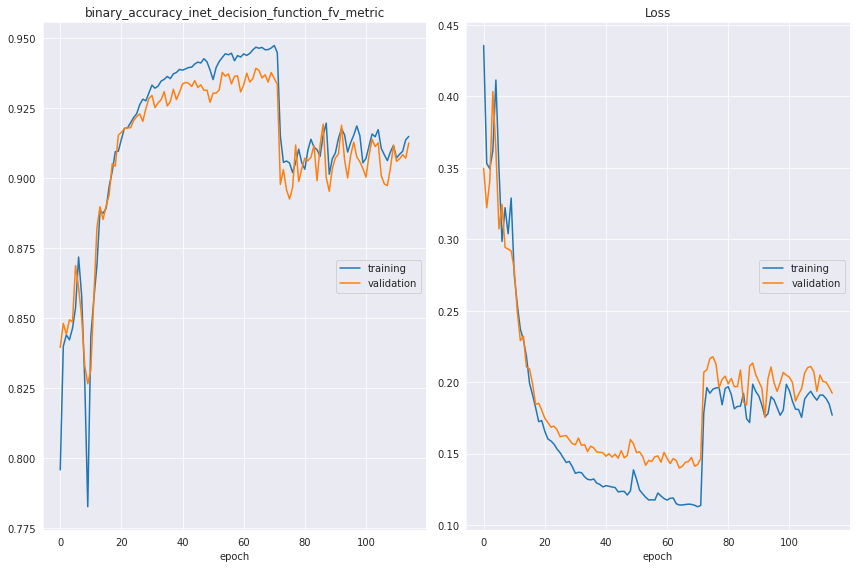

binary_accuracy_inet_decision_function_fv_metric
	training         	 (min:    0.783, max:    0.947, cur:    0.915)
	validation       	 (min:    0.827, max:    0.939, cur:    0.913)
Loss
	training         	 (min:    0.113, max:    0.436, cur:    0.177)
	validation       	 (min:    0.140, max:    0.403, cur:    0.192)
Training Time: 0:42:54
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------ LOADING MODELS -----------------------------------------------------
Loading Time: 0:00:00


<Figure size 432x288 with 0 Axes>

In [19]:
%autoreload 2
((X_valid, y_valid), 
 (X_test, y_test),
 history,

 model) = interpretation_net_training(lambda_net_dataset_train, 
                                      lambda_net_dataset_valid, 
                                      lambda_net_dataset_test,
                                      config,
                                      callback_names=['plot_losses'])



In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 321)]             0         
_________________________________________________________________
hidden1_1056 (Dense)         (None, 1056)              340032    
_________________________________________________________________
activation1_relu (Activation (None, 1056)              0         
_________________________________________________________________
dropout1_0.2 (Dropout)       (None, 1056)              0         
_________________________________________________________________
hidden2_512 (Dense)          (None, 512)               541184    
_________________________________________________________________
activation2_relu (Activation (None, 512)               0         
_________________________________________________________________
dropout2_0.1 (Dropout)       (None, 512)               0     

In [21]:
acc_target_lambda_list = []
bc_target_lambda_list = []

acc_lambda_decision_list = []
bc_lambda_decision_list = []

acc_target_decision_list = []
bc_target_decision_list = []

decision_function_parameters_list = []
decision_functio_list = []

for lambda_net in tqdm(lambda_net_dataset_test.lambda_net_list):
    
    target_function_parameters = lambda_net.target_function_parameters
    target_function = lambda_net.target_function
    
    X_test_lambda = lambda_net.X_test_lambda
    y_test_lambda = lambda_net.y_test_lambda
    
    network = lambda_net.network
    network_parameters = lambda_net.network_parameters
    
    if config['i_net']['convolution_layers'] != None or config['i_net']['lstm_layers'] != None or (config['i_net']['nas'] and config['nas_type']['convolution_layers'] != 'SEQUENTIAL'):
        network_parameters, network_parameters_flat = restructure_data_cnn_lstm(np.array([network_parameters]), config, subsequences=None)    
      
    decision_function_parameters= model.predict(np.array([network_parameters]))[0]
    decision_function = generate_decision_tree_from_array(decision_function_parameters, config)
    
    decision_function_parameters_list.append(decision_function_parameters)
    decision_functio_list.append(decision_function)
    
    y_test_network = network.predict(X_test_lambda)
    y_test_decision_function = decision_function.predict_proba(X_test_lambda)
    y_test_target_function = target_function.predict_proba(X_test_lambda)  
    
    acc_target_lambda = accuracy_score(np.round(y_test_target_function), np.round(y_test_network))
    bc_target_lambda = log_loss(np.round(y_test_target_function), y_test_network, labels=[0, 1])
    
    acc_lambda_decision = accuracy_score(np.round(y_test_network), np.round(y_test_decision_function))
    bc_lambda_decision = log_loss(np.round(y_test_network), y_test_decision_function, labels=[0, 1])        
    
    acc_target_decision = accuracy_score(np.round(y_test_target_function), np.round(y_test_decision_function))
    bc_target_decision = log_loss(np.round(y_test_target_function), y_test_decision_function, labels=[0, 1])   
    
    
    acc_target_lambda_list.append(acc_target_lambda)
    bc_target_lambda_list.append(bc_target_lambda)

    acc_lambda_decision_list.append(acc_lambda_decision)
    bc_lambda_decision_list.append(bc_lambda_decision)

    acc_target_decision_list.append(acc_target_decision)
    bc_target_decision_list.append(bc_target_decision)
    

acc_target_lambda_array = np.array(acc_target_lambda_list)
bc_target_lambda_array = np.array(bc_target_lambda_list)

acc_lambda_decision_array = np.array(acc_lambda_decision_list)
bc_lambda_decision_array = np.array(bc_lambda_decision_list)

acc_target_decision_array = np.array(acc_target_decision_list)
bc_target_decision_array = np.array(bc_target_decision_list)
    
    
acc_target_lambda = np.mean(acc_target_lambda_array)
bc_target_lambda = np.mean(bc_target_lambda_array[~np.isnan(bc_target_lambda_array)])

acc_lambda_decision = np.mean(acc_lambda_decision_array)
bc_lambda_decision = np.mean(bc_lambda_decision_array[~np.isnan(bc_lambda_decision_array)])

acc_target_decision = np.mean(acc_target_decision_array)
bc_target_decision = np.mean(bc_target_decision_array[~np.isnan(bc_target_decision_array)])


print('Accuracy Target Lambda', acc_target_lambda)
print('Binary Crossentropy Target Lambda', bc_target_lambda)
print('Accuracy Lambda Decision', acc_lambda_decision)
print('Binary Crossentropy Lambda Decision', bc_lambda_decision)
print('Accuracy Target Decision', acc_target_decision)
print('Binary Crossentropy Target Decision', bc_target_decision)


  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy Target Lambda 0.9692799999999999
Binary Crossentropy Target Lambda 0.10549376948265259
Accuracy Lambda Decision 0.7242399999999999
Binary Crossentropy Lambda Decision 1.3566034122989679
Accuracy Target Decision 0.71496
Binary Crossentropy Target Decision 1.4156571072780748


In [24]:
bc_lambda_decision_array

array([5.87835145,        nan, 0.3315129 , 1.84782498, 2.6737047 ,
       0.98578728, 2.79318077, 1.11750519, 0.04059605, 1.13371203,
       0.71593341, 0.73553898, 1.36269945, 1.21460975, 0.77976785,
       0.59619638, 2.02672674, 1.49740196, 1.98324726, 0.40103348,
       0.83884258, 1.29594132, 0.71956024, 0.89399608, 2.49531339,
       0.29574561, 0.15801875, 2.12550824, 0.30690749, 1.59527147,
       0.35149486, 1.31130772, 2.02894139, 2.31439072, 2.99973943,
       0.60090846, 0.76955028, 0.38118154, 1.24988822, 2.72524036,
       1.13304493, 0.5170824 , 0.1027604 , 2.09862221, 1.6672928 ,
       0.81063014, 3.72472238, 0.83960252, 0.65012727,        nan])

In [22]:
# TODO BENCHMARK RANDOM GUESS

In [23]:
z

NameError: name 'z' is not defined

In [ ]:
##########################################################################################################################################################################################################################
#################################################################################################### END WORKING CODE ####################################################################################################
##########################################################################################################################################################################################################################

In [ ]:
#polynomial_dict_valid_list = []
polynomial_dict_test_list = []  


for lambda_net_valid_dataset, lambda_net_test_dataset in zip(lambda_net_valid_dataset_list, lambda_net_test_dataset_list):

    #polynomial_dict_valid = {'lstsq_lambda_pred_polynomials': lambda_net_valid_dataset.lstsq_lambda_pred_polynomial_list,
    #                        'lstsq_target_polynomials': lambda_net_valid_dataset.lstsq_target_polynomial_list,
    #                        'target_polynomials': lambda_net_valid_dataset.target_polynomial_list}    

    polynomial_dict_test = {'lstsq_lambda_pred_polynomials': lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list,
                            'lstsq_target_polynomials': lambda_net_test_dataset.lstsq_target_polynomial_list,
                            'target_polynomials': lambda_net_test_dataset.target_polynomial_list}    

    #polynomial_dict_valid_list.append(polynomial_dict_valid)  
    polynomial_dict_test_list.append(polynomial_dict_test)


In [ ]:
print('---------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------- PREDICT INET ------------------------------------------------------')

start = time.time() 

for i, (X_test, model) in enumerate(zip(X_test_list, model_list)):
    #y_test_pred = model.predict(X_test)    
    #print(model.summary())
    #print(X_test.shape)
    y_test_pred = make_inet_prediction(model, X_test, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    #print(y_test_pred.shape)   
    polynomial_dict_test_list[i]['inet_polynomials'] = y_test_pred


end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('Predict Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')

In [ ]:
if symbolic_metamodeling_poly_evaluation:
    print('-------------------------------------------------- CALCULATE METAMODEL POLY -----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        
        metamodel_functions_test = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=False, force_polynomial=True)
        polynomial_dict_test_list[i]['metamodel_poly'] = metamodel_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Poly Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

In [ ]:
if symbolic_metamodeling_evaluation:
    print('---------------------------------------------------- CALCULATE METAMODEL --------------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        metamodel_functions_test = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=False, force_polynomial=False)
        polynomial_dict_test_list[i]['metamodel_functions'] = metamodel_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

In [ ]:
if symbolic_metamodeling_function_evaluation:
    print('----------------------------------------------- CALCULATE METAMODEL FUNCTION ----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        metamodel_functions_test = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=True)
        polynomial_dict_test_list[i]['metamodel_functions_no_GD'] = metamodel_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Function Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

In [ ]:
if symbolic_regression_evaluation:
    print('----------------------------------------- CALCULATE SYMBOLIC REGRESSION FUNCTION ------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        symbolic_regression_functions_test = symbolic_regression_function_generation(lambda_net_test_dataset)
        polynomial_dict_test_list[i]['symbolic_regression_functions'] = symbolic_regression_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Symbolic Regression Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------')    

In [ ]:
#%autoreload 2
if per_network_evaluation:
    print('------------------------------------------------ CALCULATE PER NETWORK POLY -----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        per_network_poly_test = per_network_poly_generation(lambda_net_test_dataset, optimization_type='scipy')
        polynomial_dict_test_list[i]['per_network_polynomials'] = per_network_poly_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Per Network Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------')

In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
print('------------------------------------------------ CALCULATE FUNCTION VALUES ------------------------------------------------')                

start = time.time() 

function_values_test_list = []
for lambda_net_test_dataset, polynomial_dict_test in zip(lambda_net_test_dataset_list, polynomial_dict_test_list):
    function_values_test = calculate_all_function_values(lambda_net_test_dataset, polynomial_dict_test)
    function_values_test_list.append(function_values_test)

end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('FV Calculation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')

In [ ]:
print('----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------')                

start = time.time() 

scores_test_list = []
distrib_dict_test_list = []

for function_values_test, polynomial_dict_test in zip(function_values_test_list, polynomial_dict_test_list):
    scores_test, distrib_test = evaluate_all_predictions(function_values_test, polynomial_dict_test)
    scores_test_list.append(scores_test)
    distrib_dict_test_list.append(distrib_test)

end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('Score Calculation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')
print('---------------------------------------------------------------------------------------------------------------------------')         


In [ ]:
identifier_type = 'epochs' if samples_list == None else 'samples'
save_results(scores_list=scores_test_list, by=identifier_type)

## Evaluate Interpretation Net

In [ ]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

In [ ]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

In [ ]:
if not optimize_decision_function:
    keys = ['inetPoly_VS_targetPoly_test', 'perNetworkPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test']
else:
    keys = ['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'perNetworkPoly_VS_predLambda_test', 'perNetworkPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test']

In [ ]:
#0.183	0.234	3.604	0.143	0.687	2.559	0.215

In [ ]:
scores_test_list[-1]

In [ ]:
distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'].values

In [ ]:
distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials'].values

In [ ]:
distrib_dict_test_list[-1]['MAE']

In [ ]:
distrib_dict_test_list[-1]['R2']

In [ ]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']))

print(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

In [ ]:
r2_values_inet = distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



In [ ]:
r2_values_lstsq_lambda = distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



In [ ]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


In [ ]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


In [ ]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


In [ ]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


In [ ]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    try:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    except:
        pass
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


In [ ]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    try:
        plt.plot(history['val_loss'])
    except:
        pass
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [ ]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [ ]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [ ]:
if len(scores_test_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [ ]:
index = 6

custom_representation_keys_fixed = ['target_polynomials', 'lstsq_target_polynomials', 'lstsq_lambda_pred_polynomials', 'lstsq_lambda_pred_polynomials']
custom_representation_keys_dynamic = ['inet_polynomials', 'per_network_polynomials']
sympy_representation_keys = ['metamodel_functions']


print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

for key in polynomial_dict_test_list[-1].keys():
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(key)
    if key in custom_representation_keys_fixed:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], force_complete_poly_representation=True, round_digits=4)
        print(polynomial_dict_test_list[-1][key][index])
    elif key in custom_representation_keys_dynamic:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], round_digits=4)
        print(polynomial_dict_test_list[-1][key][index])
    else:
        display(polynomial_dict_test_list[-1][key][index])

print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

In [ ]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

In [ ]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

In [ ]:
STOP

# BENCHMARK (RANDOM GUESS) EVALUATION

In [ ]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [ ]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

In [ ]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

In [ ]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [ ]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [ ]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

In [ ]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [ ]:
lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
current_jobs = 1

lr=0.5
max_steps = 100
early_stopping=10
restarts=2
per_network_dataset_size = 500

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

if n_jobs != -1:
    n_jobs_per_network = min(n_jobs, os.cpu_count() // current_jobs)
else: 
    n_jobs_per_network = os.cpu_count() // current_jobs - 1

printing = True if n_jobs_per_network == 1 else False


lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
if not optimize_decision_function: #target polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.target_polynomial_list)
else: #lstsq lambda pred polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list)


config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }


lambda_network_weights = lambda_network_weights_list[0]
poly_representation = poly_representation_list[0]



per_network_poly_optimization_tf(per_network_dataset_size, 
                                lambda_network_weights, 
                                  list_of_monomial_identifiers_numbers, 
                                  config, 
                                  lr=lr, 
                                  max_steps = max_steps, 
                                  early_stopping=early_stopping, 
                                  restarts=restarts, 
                                  printing=True)


# Evaluate Real Dataset


##  Auto MPG-Dataset

In [ ]:
interpretation_possible_autoMPG = False
print_head_autoMPG = None

url_autoMPG = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names_autoMPG = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset_autoMPG = pd.read_csv(url_autoMPG, names=column_names_autoMPG,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset_autoMPG = raw_dataset_autoMPG.dropna()

dataset_autoMPG['Origin'] = dataset_autoMPG['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset_autoMPG = pd.get_dummies(dataset_autoMPG, columns=['Origin'], prefix='', prefix_sep='')


features_autoMPG = dataset_autoMPG.copy()

labels_autoMPG = features_autoMPG.pop('MPG')

features_autoMPG_normalized = (features_autoMPG-features_autoMPG.min())/(features_autoMPG.max()-features_autoMPG.min())

#labels_autoMPG = (labels_autoMPG-labels_autoMPG.min())/(labels_autoMPG.max()-labels_autoMPG.min())


if features_autoMPG_normalized.shape[1] >= n:
    if n == 1:
        features_autoMPG_model = features_autoMPG_normalized[['Horsepower']]
    elif n == features_autoMPG_normalized.shape[1]:
        features_autoMPG_model = features_autoMPG_normalized
    else:
        features_autoMPG_model = features_autoMPG_normalized.sample(n=n, axis='columns')
        
    print_head_autoMPG = features_autoMPG_model.head()
    interpretation_possible_autoMPG = True

print_head_autoMPG

In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    ((lambda_index_autoMPG, 
     current_seed_autoMPG, 
     polynomial_autoMPG, 
     polynomial_lstsq_pred_list_autoMPG, 
     polynomial_lstsq_true_list_autoMPG), 
    scores_list_autoMPG, 
    pred_list_autoMPG, 
    history_autoMPG, 
    model_autoMPG) = train_nn(lambda_index=0, 
                              X_data_lambda=features_autoMPG_model.values, 
                              y_data_real_lambda=labels_autoMPG.values, 
                              polynomial=None, 
                              seed_list=[RANDOM_SEED], 
                              callbacks=[PlotLossesKerasTF()], 
                              return_history=True, 
                              each_epochs_save=None, 
                              printing=False, 
                              return_model=True)
    
    polynomial_lstsq_pred_autoMPG = polynomial_lstsq_pred_list_autoMPG[-1]

In [ ]:
if interpretation_possible_autoMPG and n==1:
    x = tf.linspace(0.0, 250, 251)
    y = model_autoMPG.predict(x)

    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
config = {
        'n': n,
        'd': d,
        'inet_loss': inet_loss,
        'sparsity': sparsity,
        'lambda_network_layers': lambda_network_layers,
        'interpretation_net_output_shape': interpretation_net_output_shape,
        'RANDOM_SEED': RANDOM_SEED,
        'nas': nas,
        'number_of_lambda_weights': number_of_lambda_weights,
        'interpretation_net_output_monomials': interpretation_net_output_monomials,
        'fixed_initialization_lambda_training': fixed_initialization_lambda_training,
        'dropout': dropout,
        'lambda_network_layers': lambda_network_layers,
        'optimizer_lambda': optimizer_lambda,
        'loss_lambda': loss_lambda,        
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }

weights_autoMPG = model_autoMPG.get_weights()

weights_flat_autoMPG = []
for layer_weights, biases in pairwise(weights_autoMPG):    #clf.get_weights()
    for neuron in layer_weights:
        for weight in neuron:
            weights_flat_autoMPG.append(weight)
    for bias in biases:
        weights_flat_autoMPG.append(bias)
        
weights_flat_autoMPG = np.array(weights_flat_autoMPG)


x = pred_list_autoMPG['X_test_lambda']
y = pred_list_autoMPG['y_test_real_lambda']

y_model_autoMPG = model_autoMPG.predict(x)




In [ ]:
if interpretation_possible_autoMPG:
    y_polynomial_lstsq_pred_autoMPG = calculate_function_values_from_polynomial(polynomial_lstsq_pred_autoMPG, x, force_complete_poly_representation=True)

    mae_model_polynomial_lstsq_pred_autoMPGy = mean_absolute_error(y_model_autoMPG, y_polynomial_lstsq_pred_autoMPG)
    mae_data_polynomial_lstsq_pred_autoMPG = mean_absolute_error(y, y_polynomial_lstsq_pred_autoMPG)

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQt Poly:')
    print_polynomial_from_coefficients(y_polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('MAE Model: ', mae_model_polynomial_lstsq_pred_autoMPGy)
    print('MAE Data: ', mae_data_polynomial_lstsq_pred_autoMPG)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    interpretation_net = model_list[-1]
    
    start = time.time() 
    
    #interpretation_net_poly = interpretation_net.predict(np.array([weights_flat_autoMPG]))[0]
    interpretation_net_poly = make_inet_prediction(interpretation_net, weights_flat_autoMPG, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_interpretation_net_poly = calculate_function_values_from_polynomial(interpretation_net_poly, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_interpretation_net_poly)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_interpretation_net_poly)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)    
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:

    start = time.time() 
    
    if False:
        per_network_hyperparams = {
            'optimizer':  'Powell',
            'jac': 'fprime',
            'max_steps': 5000,#100,
            'restarts': 3,
            'per_network_dataset_size': 500,
        }      
        
        per_network_function =  per_network_poly_optimization_scipy(per_network_dataset_size, 
                                                                  weights_flat_autoMPG, 
                                                                  list_of_monomial_identifiers_numbers, 
                                                                  config, 
                                                                  optimizer = per_network_hyperparams['optimizer'],
                                                                  jac = per_network_hyperparams['jac'],
                                                                  max_steps = per_network_hyperparams['max_steps'], 
                                                                  restarts=per_network_hyperparams['restarts'], 
                                                                  printing=True,
                                                                  return_error=False)
    else:
        per_network_hyperparams = {
            'optimizer': tf.keras.optimizers.RMSprop,
            'lr': 0.02,
            'max_steps': 500,
            'early_stopping': 10,
            'restarts': 3,
            'per_network_dataset_size': 5000,
        }   
        
        per_network_function =  per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                              weights_flat_autoMPG, 
                                                              list_of_monomial_identifiers_numbers, 
                                                              config, 
                                                              optimizer = per_network_hyperparams['optimizer'],
                                                              lr=per_network_hyperparams['lr'], 
                                                              max_steps = per_network_hyperparams['max_steps'], 
                                                              early_stopping=per_network_hyperparams['early_stopping'], 
                                                              restarts=per_network_hyperparams['restarts'], 
                                                              printing=True,
                                                              return_error=False)
            
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)  
    
    y_per_network_function = calculate_function_values_from_polynomial(per_network_function, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_per_network_function)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_per_network_function)    
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)       
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    
    symbolic_regression_hyperparams = {
        'dataset_size': 500,
    }

    start = time.time() 
    
    symbolic_regression_function =  symbolic_regression(model_autoMPG, 
                                                      config,
                                                      symbolic_regression_hyperparams,
                                                      #printing = True,
                                                      return_error = False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    variable_names = ['X' + str(i) for i in range(n)]
    
    y_symbolic_regression_function = calculate_function_values_from_sympy(symbolic_regression_function, x, variable_names=variable_names)
    
    mae_model_symbolic_regression_function = mean_absolute_error(y_model_autoMPG, y_symbolic_regression_function)
    mae_data_symbolic_regression_function = mean_absolute_error(y, y_symbolic_regression_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Poly:')    
    display(symbolic_regression_function)
    print('MAE Model: ', mae_model_symbolic_regression_function)
    print('MAE Data: ', mae_data_symbolic_regression_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG and True:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = False,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function = calculate_function_values_from_sympy(metamodel_function, x)
    
    mae_model_metamodel_function = mean_absolute_error(y_model_autoMPG, y_metamodel_function)
    mae_data_metamodel_function = mean_absolute_error(y, y_metamodel_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')    
    display(metamodel_function)
    print('MAE Model: ', mae_model_metamodel_function)
    print('MAE Data: ', mae_data_metamodel_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function_basic =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = True,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function_basic = calculate_function_values_from_sympy(metamodel_function_basic, x)
    
    mae_metamodel_function_basic = mean_absolute_error(y_model_autoMPG, y_metamodel_function_basic)
    mae_metamodel_function_basic = mean_absolute_error(y, y_metamodel_function_basic)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function Basic:')    
    display(metamodel_function_basic)
    print('MAE Model: ', mae_metamodel_function_basic)
    print('MAE Data: ', mae_metamodel_function_basic)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQ Poly:')
    print_polynomial_from_coefficients(polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Function:')
    display(symbolic_regression_function)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')
    display(metamodel_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function Basic:')
    #display(metamodel_function_basic)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
if interpretation_possible_autoMPG and n==1:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    
    ax.set_ylim([0,50])
    
    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.scatter(x, y, label='Test Data')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_model_autoMPG))]) , label='Model Predictions')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_interpretation_net_poly))]) , label='Interpretation Net Poly')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_per_network_function))]) , label='Per Network Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_polynomial_lstsq_pred_autoMPG))]) , label='LSTSQ Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_symbolic_regression_function))]) , label='Symbolic Regression Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_metamodel_function))]) , label='Metamodel Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y))]) y_metamodel_function_basic, label='Metamodel Function Basic')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
sample_data_X = np.array([i for i in range(1000)])
sample_data_y = np.array([3*i for i in range(1000)])

current_seed = 42

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y*1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y+1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:


model_2_weights = model.get_weights()
model_2_normalized_weights = model_2_weights #[weights/10 for weights in model_2_weights]


model_2_normalized_weights[-6] = model_2_normalized_weights[-6]/10
model_2_normalized_weights[-5] = model_2_normalized_weights[-5]/10

model_2_normalized_weights[-4] = model_2_normalized_weights[-4]/10
model_2_normalized_weights[-3] = model_2_normalized_weights[-3]/100

model_2_normalized_weights[-2] = model_2_normalized_weights[-2]/10
model_2_normalized_weights[-1] = model_2_normalized_weights[-1]/1000

model_2.set_weights(model_2_normalized_weights)

print(model_2.get_weights())
print(model_2.predict([1, 10]))

# Evaluate Per-Network Poly Optimization

## Example Optimization (Common Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer':  'Powell',
    'jac': 'fprime',
    'max_steps': 5000,#100,
    'restarts': 3,
    'per_network_dataset_size': 500,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_scipy(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      jac = per_network_hyperparams['jac'],
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Example Optimization (Neural Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer': tf.keras.optimizers.RMSprop,
    'lr': 0.02,
    'max_steps': 500,
    'early_stopping': 10,
    'restarts': 3,
    'per_network_dataset_size': 5000,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      lr = per_network_hyperparams['lr'], 
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      early_stopping = per_network_hyperparams['early_stopping'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error.numpy()))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Grid Search Common Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 10

per_network_hyperparams = {
    'optimizer':  [
                   'Nelder-Mead', 
                   'Powell', 
        
                   'CG',
                   'BFGS',
                   'Newton-CG', 
                   #'L-BFGS-B', #'>' not supported between instances of 'int' and 'NoneType'
                   'TNC', 
                   
                   'COBYLA', 
                   'SLSQP', 
                   
                   #'trust-constr', # TypeError: _minimize_trustregion_constr() got an unexpected keyword argument 'maxfun'
                   #'dogleg', # ValueError: Hessian is required for dogleg minimization
                   #'trust-ncg', #ValueError: Either the Hessian or the Hessian-vector product is required for Newton-CG trust-region minimization
                   #'trust-exact', # ValueError: Hessian matrix is required for trust region exact minimization.
                   #'trust-krylov' #ValueError: Either the Hessian or the Hessian-vector product is required for Krylov trust-region minimization
                   ], 
    'jac': ['fprime'],
    'max_steps': [5000],#100,
    'restarts': [3],
    'per_network_dataset_size': [500],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_scipy)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  jac = params['jac'],
                                                                                  max_steps = params['max_steps'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

## Grid Search Neural Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 100

per_network_hyperparams = {
    'optimizer': [tf.keras.optimizers.RMSprop], #[tf.keras.optimizers.SGD, tf.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adadelta]
    'lr': [0.02], #[0.5, 0.25, 0.1, 0.05, 0.025]
    'max_steps': [5000],#100,
    'early_stopping': [10],
    'restarts': [3],
    'per_network_dataset_size': [5000],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_tf)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  lr = params['lr'], 
                                                                                  max_steps = params['max_steps'], 
                                                                                  early_stopping = params['early_stopping'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()